In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import cv2
import msgpack as mp
import msgpack_numpy as mpn
from cv2 import aruco
from ultralytics import YOLO
from tqdm import tqdm

import sys
sys.path.append('..')
from support.pd_support import *
from scipy.signal import savgol_filter

In [2]:
_webcam_calib_folder = r"C:\Users\CMC\Documents\openposelibs\pose\armbo\recording_programs\test_data\omni_cam_9d0f_may_8_2023\calibration_00"
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]
_webcam_video_pth = os.path.join(_webcam_calib_folder, "webcam_color.msgpack")
_webcam_timestamp_pth = os.path.join(_webcam_calib_folder, "webcam_timestamp.msgpack")

with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
    webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _webcam_rot = next(webcam_rotmat)
    _webcam_org = next(webcam_rotmat)
print("camera matrix", _webcam_cam_mat)
print("distortion", _webcam_dist)



camera matrix [[      880.2           0      358.28]
 [          0      881.87      242.71]
 [          0           0           1]]
distortion [[    0.12433    -0.12033  -0.0029946  -0.0011585     -3.9928]]


In [3]:
_video_pth = r"C:\Users\CMC\Documents\openposelibs\pose\armbo\recording_programs\test_data\omni_cam_9d0f_may_8_2023\sk36_30_random_01\webcam_color.msgpack"
_timestamp_pth = r"C:\Users\CMC\Documents\openposelibs\pose\armbo\recording_programs\test_data\omni_cam_9d0f_may_8_2023\sk36_30_random_01\webcam_timestamp.msgpack"

_vid_file = open(_video_pth, "rb")
unpacker = mp.Unpacker(_vid_file, object_hook=mpn.decode)
_video_data = [msg for msg in unpacker]

_tfile = open(_timestamp_pth, "rb")
unpacker = mp.Unpacker(_tfile, object_hook=mpn.decode)
_time = [msg for msg in unpacker]

Aruco detection

In [4]:
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_ARUCO_ORIGINAL)
markerLength = 0.05
markerSeparation = 0.01

board = aruco.GridBoard_create(
        markersX=1,
        markersY=1,
        markerLength=markerLength,
        markerSeparation=markerSeparation,
        dictionary=ARUCO_DICT)

In [5]:
#yolo model

model = YOLO("aruco_2.pt")

AttributeError: Can't get attribute 'v8PoseLoss' on <module 'ultralytics.yolo.utils.loss' from 'c:\\Users\\CMC\\anaconda3\\envs\\py310\\lib\\site-packages\\ultralytics\\yolo\\utils\\loss.py'>

In [ ]:
aruco_lib = {"x":[], "y":[], "z":[]}
dl_lib = {"x":[], "y":[], "z":[]}

for i in tqdm(range(len(_video_data))):
        # using aruco library
        corners, ids, rejected_img_points = aruco.detectMarkers(_video_data[i], ARUCO_DICT, parameters=ARUCO_PARAMETERS)
        corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
                image = _video_data[0],
                board = board,
                detectedCorners = corners,
                detectedIds = ids,
                rejectedCorners = rejected_img_points,
                cameraMatrix = _webcam_cam_mat,
                distCoeffs = _webcam_dist)

        rvec, tvec, _ = aruco.estimatePoseSingleMarkers(corners, 0.05, _webcam_cam_mat, _webcam_dist)
        if tvec is None:
                aruco_lib["x"].append(np.nan)
                aruco_lib["y"].append(np.nan)
                aruco_lib["z"].append(np.nan)

        else:
                aruco_lib["x"].append(tvec[0][0][0])
                aruco_lib["y"].append(tvec[0][0][1])
                aruco_lib["z"].append(tvec[0][0][2])

        color_img = _video_data[i].copy()
        color_img = cv2.cvtColor(color_img, cv2.COLOR_GRAY2RGB)
        #model inference
        result = model.predict(color_img, verbose=False)
        modelcorners = result[0].keypoints.data.numpy()
        modelcorners = [modelcorners[0][:4]]

        rvec_m, tvec_m, _ = aruco.estimatePoseSingleMarkers(modelcorners, 0.05, _webcam_cam_mat, _webcam_dist)

        if tvec_m is None:
                dl_lib["x"].append(np.nan)
                dl_lib["y"].append(np.nan)
                dl_lib["z"].append(np.nan)
        else:
                dl_lib["x"].append(tvec_m[0][0][0])
                dl_lib["y"].append(tvec_m[0][0][1])
                dl_lib["z"].append(tvec_m[0][0][2])

100%|██████████| 1963/1963 [06:50<00:00,  4.78it/s]


In [ ]:
ar_df = pd.DataFrame()
ar_df["x"] = aruco_lib["x"]
ar_df["y"] = aruco_lib["y"]
ar_df["z"] = aruco_lib["z"]
ar_df["time"] = _time
ar_df["time"] = pd.to_datetime(ar_df["time"])

yolo_df = pd.DataFrame()
yolo_df["x"] = dl_lib["x"]
yolo_df["y"] = dl_lib["y"]
yolo_df["z"] = dl_lib["z"]
yolo_df["time"] = _time
yolo_df["time"] = pd.to_datetime(yolo_df["time"])

In [ ]:
def transform_coordinates_1(df, rotmat, org, correction=False, translation_correction=None):
    df1 = df.copy( deep=True)
    if translation_correction is None:
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)

    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        _val = rotmat.T @ _temp
        if correction:
            _val = _val - translation_correction
        
        df1["x"].replace({df1["x"].loc[i]: _val[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: _val[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: _val[2]}, inplace=True)

    return df1

In [ ]:
_mocap_pth = r"C:\Users\CMC\Documents\openposelibs\pose\armbo\recording_programs\test_data\omni_cam_9d0f_may_8_2023\sk36\sk36_30_random_01.csv"
_m_df, st_time = read_rigid_body_csv(_mocap_pth)
_m_df = add_datetime_col(_m_df, st_time, "seconds")

# Mocap markers in aruco plate
_ar_tr = get_rb_marker_name(7)
_ar_tl = get_rb_marker_name(2)
_ar_br = get_rb_marker_name(3)
_ar_bl = get_rb_marker_name(1)

_mocap_ar = pd.DataFrame()
_mocap_ar["time"] = _m_df["time"]
_mocap_ar["x"] = _m_df[_ar_tr["x"]] + _m_df[_ar_tl["x"]] + _m_df[_ar_br["x"]] + _m_df[_ar_bl["x"]]
_mocap_ar["y"] = _m_df[_ar_tr["y"]] + _m_df[_ar_tl["y"]] + _m_df[_ar_br["y"]] + _m_df[_ar_bl["y"]]
_mocap_ar["z"] = _m_df[_ar_tr["z"]] + _m_df[_ar_tl["z"]] + _m_df[_ar_br["z"]] + _m_df[_ar_bl["z"]]

_mocap_ar["x"] = _mocap_ar["x"] / 4
_mocap_ar["y"] = _mocap_ar["y"] / 4
_mocap_ar["z"] = _mocap_ar["z"] / 4

In [ ]:
_ar_df = transform_coordinates_1(ar_df, _webcam_rot, _webcam_org, correction=True)
_ar_df["time"] = pd.to_datetime(_ar_df["time"])
_yolo_df = transform_coordinates_1(yolo_df, _webcam_rot, _webcam_org, correction=True)
_yolo_df["time"] = pd.to_datetime(_yolo_df["time"])

In [ ]:
_yolo_df.time.iloc[0]

Timestamp('2023-05-08 15:10:42.566939')

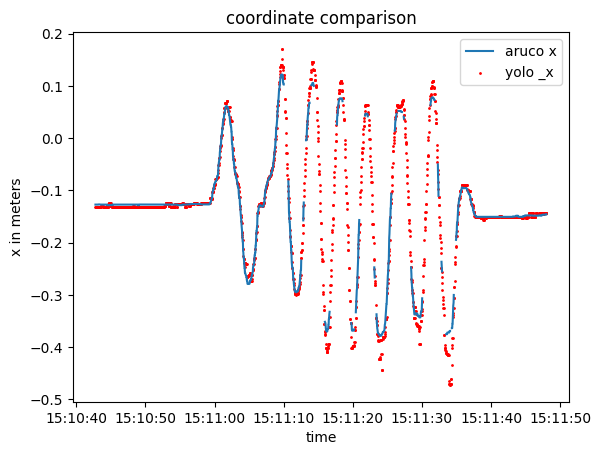

In [ ]:
plt.plot(_ar_df["time"], _ar_df["x"].rolling(7).median() + 0.01, label="aruco x")
plt.scatter(_yolo_df["time"], _yolo_df["x"].rolling(7).median() + 0.01, label="yolo _x", color = 'red', s=1)
# plt.plot(_mocap_ar["time"], _mocap_ar["x"], label = 'mocap x')
plt.title("coordinate comparison")
plt.xlabel("time")
plt.ylabel("x in meters")
plt.legend()

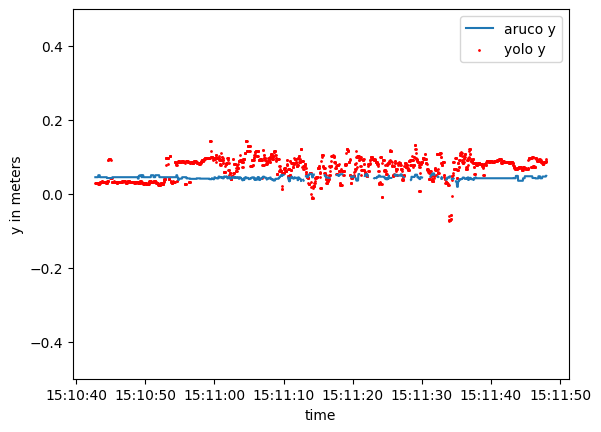

In [ ]:
plt.plot(_ar_df["time"], _ar_df["y"].rolling(7).median(), label="aruco y")
plt.scatter(_yolo_df["time"], _yolo_df["y"].rolling(7).median() +0.06, label="yolo y", color = 'red', s=1)
# plt.plot(_mocap_ar["time"], _mocap_ar["y"], label = 'mocap y')
plt.ylabel("y in meters")
plt.ylim(-0.5, 0.5)
plt.xlabel("time")
plt.legend()

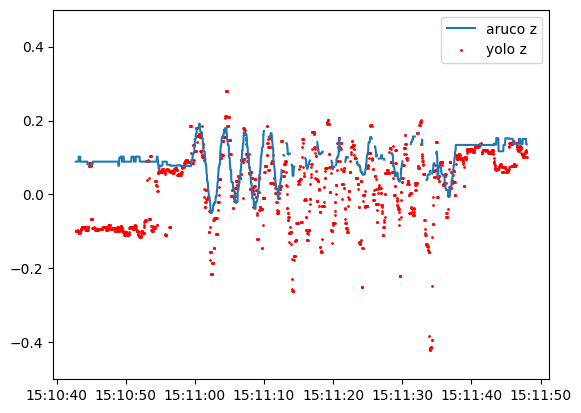

In [ ]:
plt.plot(_ar_df["time"], _ar_df["z"].rolling(7).median(), label="aruco z")
# plt.plot(_ar_df["time"], _ar_df["z"], label="aruco z")
plt.scatter(_yolo_df["time"], _yolo_df["z"].rolling(7).median(), label="yolo z", color = 'red', s=1)
# plt.plot(_yolo_df["time"], _yolo_df["z"], label="yolo z")
# plt.plot(_mocap_ar["time"], _mocap_ar["z"], label = 'mocap z')
plt.ylim(-0.5, 0.5)
plt.legend()